# Efficiently Representing Faces

##### (Notebook By Itay Hazan)

In [16]:
import re
import numpy as np
import matplotlib.pyplot as plt

In this exercise, we will try to reduce the dimension of a dataset of black-and-white images of faces.
The `BioID-FaceDatabase` dataset consists of 1521 gray level images with a resolution of 286x384 pixels. Each one shows the frontal view of a face of one out of 23 different test persons. The images are labeled "BioID_xxxx.pgm" where the characters xxxx are replaced by the index of the current image (with leading zeros). Similar to this, the files "BioID_xxxx.eye" contain the eye positions for the corresponding images. We will not be using the eye positions in this exercise.

For your convenience, the code below reads a `pgm` image into a numpy array.

In [26]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

An example of reading and displaying the images is shown below:

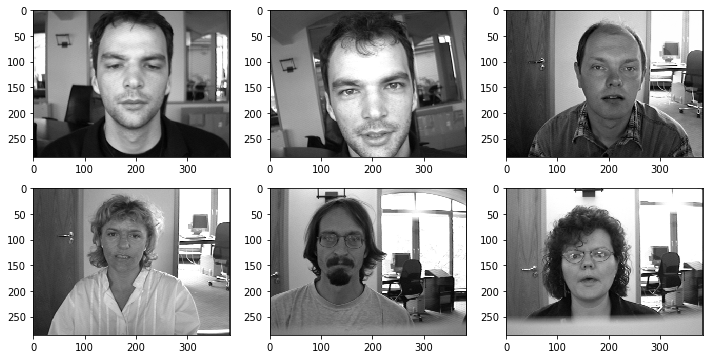

In [64]:
f, axarr = plt.subplots(2,3, figsize=(12, 6))
axarr[0,0].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0000.pgm"), plt.cm.gray)
axarr[0,1].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0025.pgm"), plt.cm.gray)
axarr[0,2].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0200.pgm"), plt.cm.gray)
axarr[1,0].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0300.pgm"), plt.cm.gray)
axarr[1,1].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0400.pgm"), plt.cm.gray)
axarr[1,2].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0500.pgm"), plt.cm.gray)

plt.show()

## Step 1: Read all the images into a numpy array

Read the images into a numpy array, where each image is a `(width x height)` row. 

In [71]:
def read_images(num_images=400, image_width=384, image_height=286):
    X = np.zeros([num_images, image_width*image_height])
    for i in range(num_images):
        padded_i = '{:04}'.format(i)
        X[i, :] = read_pgm("BioID-FaceDatabase-V1.2/BioID_" + padded_i + ".pgm").reshape(-1)
    return X

Display the first 10 images:

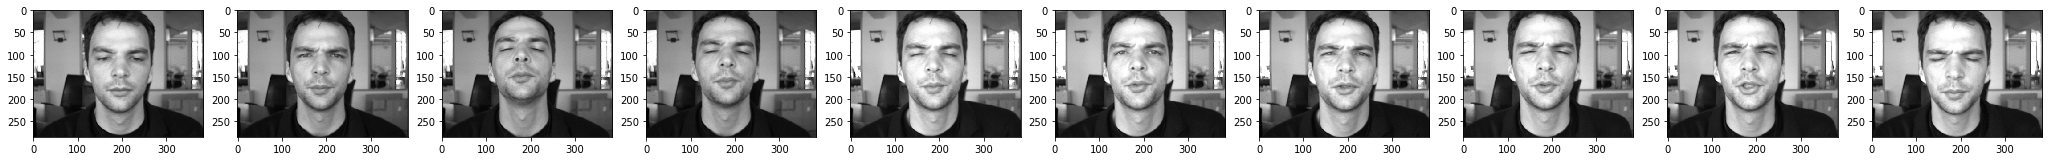

In [75]:
width=384
height=286
X = read_images()
f, axarr = plt.subplots(1,10, figsize=(36, 12))
for i in range(10):
    axarr[i].imshow(X[i,:].reshape((int(height), int(width))), plt.cm.gray)
plt.show()

## Step 2: Extract Principle Components

We will now find the principle components of our input using SVD.

First, we compute the mean sample (i.e. the mean of all rows):

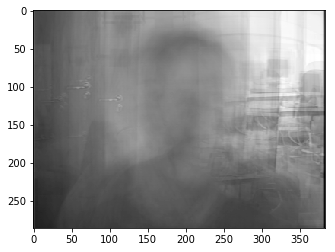

In [95]:
mean = X.mean(axis=0)
# f, axarr = plt.subplots(1,1, figsize=(36, 12))
plt.imshow(mean.reshape((int(height), int(width))), plt.cm.gray)

Now, normalize the input (i.e. reduce the mean sample from all rows)

In [83]:
normal_X = X - mean

Display the first 10 images of `normal_X`:

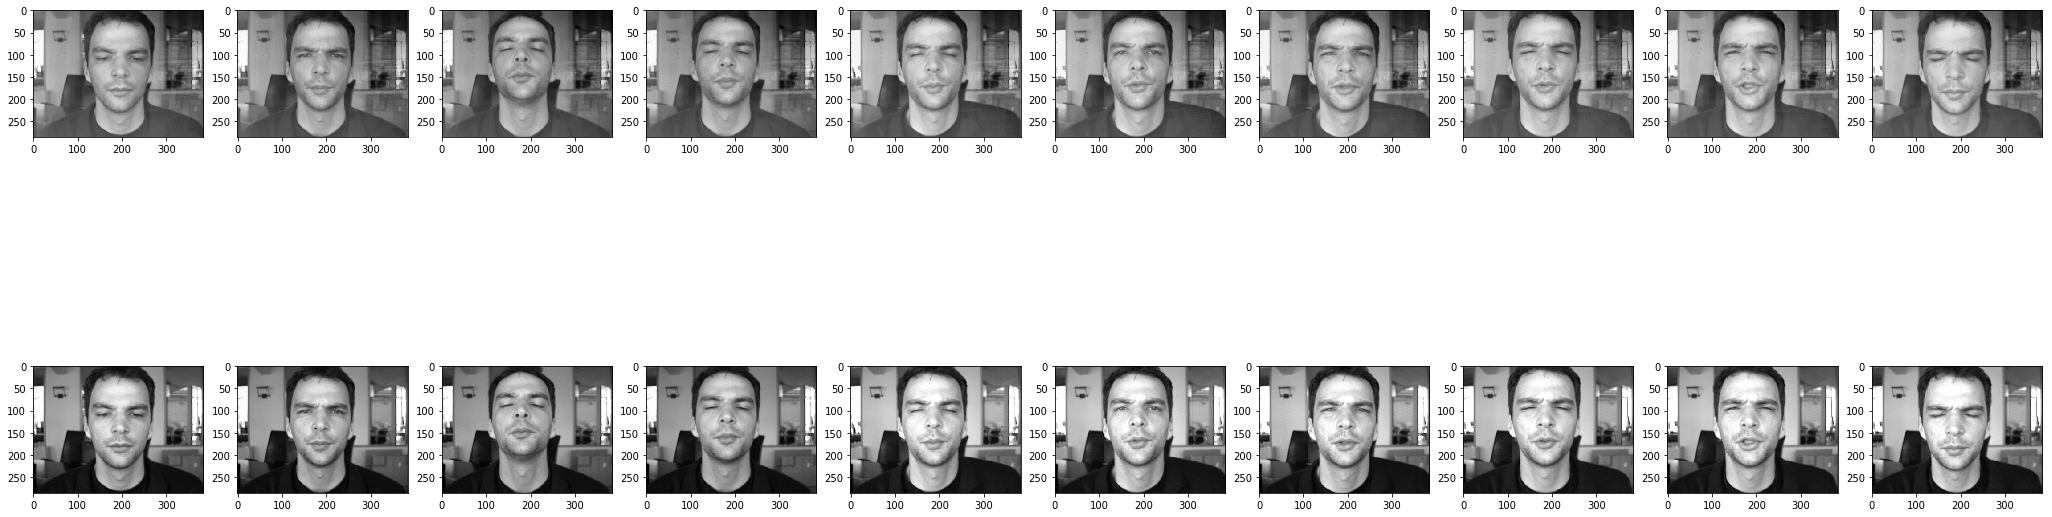

In [84]:
width=384
height=286
f, axarr = plt.subplots(2,10, figsize=(36, 12))
for i in range(10):
    axarr[0, i].imshow(normal_X[i,:].reshape((int(height), int(width))), plt.cm.gray)
for i in range(10):
    axarr[1, i].imshow(X[i,:].reshape((int(height), int(width))), plt.cm.gray)
plt.show()

Compute the singular value decomposition of `normal_X` using `numpy`'s (or `scipy`'s) implementation of SVD. You may use the flag `full_matrices = False`.

In [88]:
U, S, Vt = np.linalg.svd(normal_X, full_matrices=False)

[[-0.0431203  -0.03831388 -0.08543135 ...  0.00301544 -0.00356817
  -0.05      ]
 [-0.03671194 -0.03381566 -0.0900059  ... -0.00371015 -0.00142927
  -0.05      ]
 [-0.03205222 -0.0313112  -0.08739561 ...  0.00445962  0.00297849
  -0.05      ]
 ...
 [ 0.00116796  0.01692228  0.09360717 ...  0.00646411  0.0014661
  -0.05      ]
 [ 0.00089017  0.01495193  0.09985806 ... -0.00182885  0.00100981
  -0.05      ]
 [ 0.00413561  0.01652797  0.10243596 ... -0.01193678 -0.00292225
  -0.05      ]]


Print the shapes of `U, S, Vt`.

In [89]:
print(U.shape)
print(S.shape)
print(Vt.shape)

(400, 400)
(400,)
(400, 109824)


As you recall, we have found a decomposition of `normal_X` such that $ \text{normal_X} = U S V^T $. 
$V$'s columns ($V^T$'s rows) are the **principle axes**, that is the new basis we found that spans the rows of `normal_X`. $(U S)$'s rows are the **principle components** of `normal_X`, that is the coefficients of the rows of `normal_X` in the PCA basis $V$.

Check that `normal_X` is indeed equal to $ U S V^T $. Use the method `np.allclose`.

In [92]:
X_a = U @ np.diag(S) @ Vt
print(np.isclose(normal_X, X_a).all())

True


Display the first 10 principle axes.

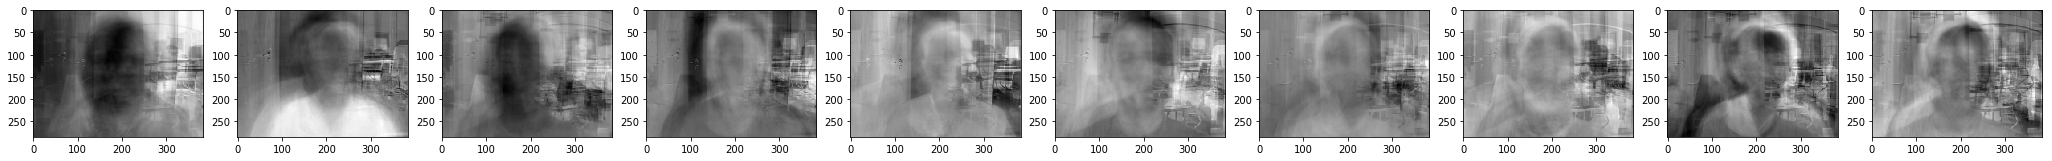

In [93]:
width=384
height=286
f, axarr = plt.subplots(1,10, figsize=(36, 12))
for i in range(10):
    axarr[i].imshow(Vt[i,:].reshape((int(height), int(width))), plt.cm.gray)

## Step 3: Generate random faces

As mentioned above, the columns of $V$ are a PCA basis for representing faces. Namely, if we sample a random coefficient vector $c$ (with the same number of coefficients as the number of columns in $V$, then $c \cdot V^T$ will result in a random face sampled from the subspace of faces $V$ represents.

Sample 5 different values of $c$, and display the resulting faces.

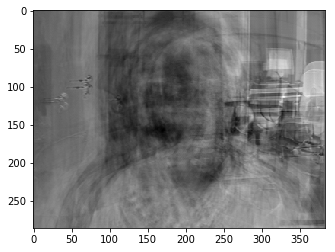

In [135]:
c1 = np.random.uniform(low=1, high=255, size=400)
sumc1=np.sum(c1)
normal_c1 = c1/sumc1
random1 = normal_c1 @ np.diag(S) @ Vt
plt.imshow(random1.reshape((int(height), int(width))), plt.cm.gray)

## Step 4: Dimensionality Reduction

To reduce the dimensionality of `normal_X`, we only take the first $ d = 100 $ principle axes. 

In [124]:
truncated_S = S[0:100]
truncated_Vt = Vt[0:100, :]

(100,)
(100, 109824)


Define `compressed_normal_X` to be the multiplication of `U`, `truncated_S`, and `truncated_Vt`.

In [139]:
Stag=np.zeros([400,100])
Stag=Stag[0:100,:]+np.diag(truncated_S)
Stag.shape
compressed_normal_X = U @ Stag @ truncated_Vt

ValueError: shapes (400,400) and (100,100) not aligned: 400 (dim 1) != 100 (dim 0)

Define `compressed_X` to be the `compressed_normal_X` plus the mean sample `mean`.

In [122]:
compressed_X = compressed_normal_X + mean

Display the first 5 original images (first 5 rows of X) next to their compressed counterparts (first 5 rows of compressed_X):

IndexError: too many indices for array

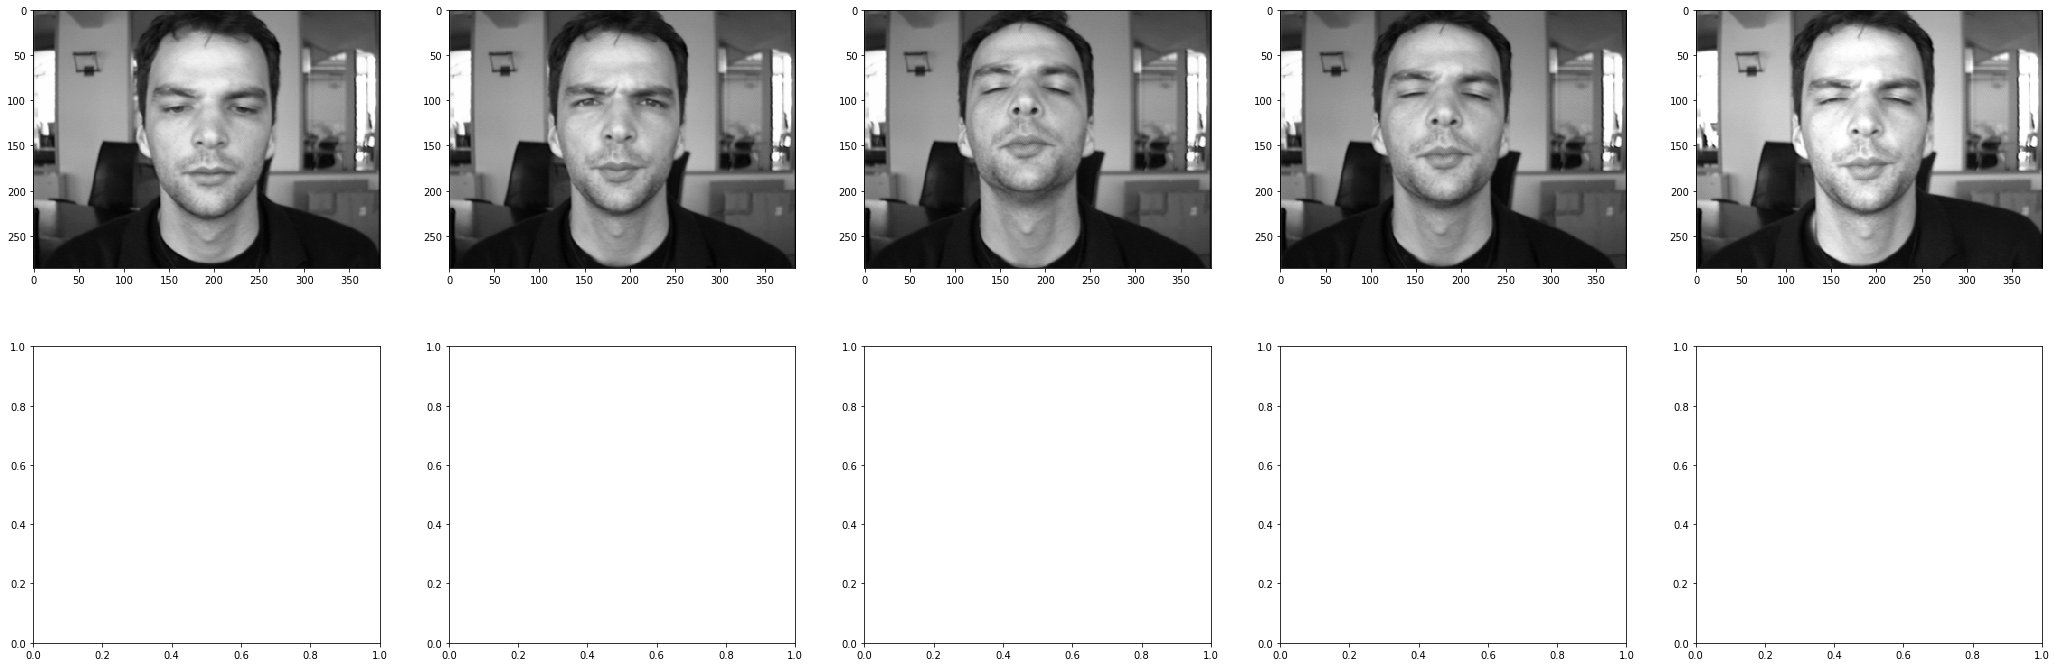

In [123]:
width=384
height=286
f, axarr = plt.subplots(2,5, figsize=(36, 12))
for i in range(5):
    axarr[0, i].imshow(X[i,:].reshape((int(height), int(width))), plt.cm.gray)
for i in range(5):
    axarr[1, i].imshow(compressed_X[i,:].reshape((int(height), int(width))), plt.cm.gray)
plt.show()

Define a matrix `se` to represent the squared error between the original images and the compressed ones, that is: `se` will be a matrix with the same shape as `X` and `compressed_X`, and `se[i,j] = (X[i,j]-compressed_X[i,j])**2` for each entry `(i,j)`.

In [12]:
se = None # TODO

Draw a heat map that shows the error in each pixel of the first image (that is, draw a heatmap of `se[0,:]`). 

In [14]:
# TODO: draw heat map

## Step 5: Try Other Values of $d$ 

Repeat step 4 with other values of $d$, and evaluate the results. Try to reduce the values of $d$ (100, 60, 30, 10), and evaluate your results.

## Step 6: (Optional) Use sklearn's implementation of PCA

Repeat step 2, but now using `sklearn`'s implementation of PCA.